# **Mount Google** **Drive**

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [2]:
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

 An_Xception_Based_Convolutional_Neural_Network_for_Scene_Image_Classification_with_Transfer_Learning.pdf
'Application for Lease- Form for Email (Applicant) (1).gdoc'
'Application for Lease- Form for Email (Applicant).gdoc'
'Application for Lease- Form for Email (Applicant).pdf'
'Colab Notebooks'
'CV -Xizhi Wu.pdf'
'FOW Documents'
 MyDrive
'NT15 LEASE 2021.gdoc'
'NT15 LEASE 2021.pdf'
 Xizhi_Wu_UnderGrad_Transcript.pdf


In [3]:
%cd mydrive/FOW Documents

/content/gdrive/MyDrive/FOW Documents


In [4]:
!ls

 best_model			      new_ValAcc_history.csv
 checkpoint			      new_ValAcc_historylr.csv
'crawler text.ipynb'		      new_ValLoss_history.csv
 FOW_bert.ipynb			      new_ValLoss_historylr.csv
'FOW Document Codings - Sheet1.csv'   Presentation_FOW.pptx
 Loss_history.csv		      Text_Attempt1.csv
 Macro_history.csv		      Text_Attempt2.csv
 Micro_history.csv		      Text_Attempt3.csv
 new_Loss_history.csv		      Text_Attempt3.xlsx
 new_Loss_historylr.csv		      Text.csv
 new_Macro_history.csv		      TrainAcc_history.csv
 new_Macro_historylr.csv	      ValAcc_history.csv
 new_Micro_history.csv		      ValLoss_history.csv
 new_Micro_historylr.csv	     '新建 Microsoft Excel 工作表.xlsx'
 new_TrainAcc_history.csv	      新建文本文档.txt
 new_TrainAcc_historylr.csv


# **Importing Libraries**

In [13]:
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 8.4 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 49.4 MB/s 
     |████████████████████████████████| 636 kB 37.6 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 109 kB 50.3 MB/s 
     |████████████████████████████████| 546 kB 49.0 MB/s 


In [14]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


In [15]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# **Pre-processing the training** **data** 

In [8]:
train=pd.read_csv("Text_Attempt3.csv")
train

,ID,Title,URL,Text,Year_of_publication,Document_attribute,Document_genre,Document_Geographical_focus,Doc_Number_of_pages,Addr_Policy Makers/Civilry,Employers/associations,Employees/associations,Educational Institution(s)/ Academia,Prior_1.1.1.1.,Prior_1.1.1.2.,Prior_1.1.1.3.,Prior_1.1.1.4.,Prior_1.1.2.1.,Prior_1.1.2.2.,Prior_1.1.2.3.,Prior_1.1.2.4.,Prior_1.1.3.,Prior_1.1.4.,Prior_1.1.5.,Prior_1.2.1.,Prior_1.2.2.,Prior_1.2.3.,Prior_1.2.4,Prior_1.2.5,Prior_1.3.1.,Prior_1.3.2.,Prior_1.3.3.,Prior_1.4.1.,Prior_1.4.2.,Prior_1.4.3.,Prior_2.1.1.,Prior_2.1.2.,Prior_2.1.3.,Prior_2.2.1.,Prior_2.2.2.,...,Reco_1.4.1.,Reco_1.4.2.1.,Reco_1.4.2.2.,Reco_1.5.1.,Reco_1.5.2.,Reco_1.5.3.,Reco_1.5.4.,Reco_1.5.5.,Reco_2.1.1.1.,Reco_2.1.1.2.,Reco_2.1.2.1.,Reco_2.1.2.2.,Reco_2.1.2.3.,Reco_2.2.1.,Reco_2.2.2.,Reco_2.2.3.,Reco_2.2.2.1.,Reco_2.2.2.2.,Reco_2.2.2.3.,Reco_2.2.2.4.,Reco_2.2.2.5.,Reco_2.3.1.,Reco_2.3.2.,Reco_2.3.3.,Reco_2.4.1.,Reco_2.4.2.,Reco_3.1.1.,Reco_3.1.2.,Reco_3.1.3.,Reco_3.1.4.,Reco_3.1.5.,Reco_3.2.1.,Reco_3.2.2.,Reco_3.2.3.,Reco_3.3.1.1.,Reco_3.3.1.2.,Reco_3.3.2.1.,Reco_3.3.2.2.,Reco_3.3.2.3.,Reco_3.3.3.2.
0,1,TECHNOLOGY AT WORK v2.0 - The Future Is Not Wh...,https://www.oxfordmartin.ox.ac.uk/downloads/re...,TECHNOLOGY AT WORK v2.0\nThe Future Is Not Wha...,2016.0,NaN,Report,NaN,156,1.0,1.0,1.0,NaN,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,...,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,1,0,0,0,0
1,2,"A FUTURE THAT WORKS: AUTOMATION, EMPLOYMENT, A...",https://www.mckinsey.com/~/media/mckinsey/feat...,"A FUTURE THAT WORKS: \nAUTOMATION, EMPLOYMENT,...",2017.0,Research,Report,Global,148,1.0,1.0,1.0,NaN,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,1,0,...,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0
2,4,The Future of Work: Regional Perspectives,https://www.afdb.org/fileadmin/uploads/afdb/Do...,African Development Bank\nAsian Development Ba...,2018.0,NaN,NaN,Global,118,1.0,1.0,1.0,NaN,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,...,1,0,1,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,5,World Development Report 2019: THE CHANGING NA...,http://documents.worldbank.org/curated/en/8162...,A World Bank Group Flagship Report\nWORLD DEVE...,2018.0,NaN,Report,Global,151,1.0,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,6,Technology and the Future of Work,https://www.imf.org/external/np/g20/pdf/2018/0...,TECHNOLOGY AND FUTURE OF WORK \nGROUP OF TWENT...,2018.0,Background,Note,Global,33,1.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,234,The rise of the «just-in-time workforce»: On-d...,https://www.ilo.org/wcmsp5/groups/public/---ed...,The rise of the «just-in-time workforce»: \nOn...,2016.0,NaN,NaN,Global,43,1.0,NaN,1.0,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112,235,The Global Human Capital Report 2017. Preparin...,http://www3.weforum.org/docs/WEF_Global_Human_...,Insight Report\nThe Global \nHuman Capital Re...,2017.0,Insight,Report,Global,203,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113,236,"Organizing on-demand: Representation,voice, an...",https://www.ilo.org/wcmsp5/groups/public/---ed...,"Organizing on-demand: \nRepresentation,voice, ...",2018.0,NaN,NaN,Global,53,1.0,NaN,1.0,NaN,0,0,

In [ ]:
train['labels']=train[train.columns[13:134]].values.tolist()
train_data=train[['Text','labels']].copy()

In [ ]:
sample_row = train_data.iloc[16]
sample_comment = sample_row.Text
sample_labels = sample_row['labels']
print(sample_comment)
print(sample_labels)

P O L I C Y B R I E F O N T H E F U T U R E O F W O R K 
The Future of Soc ial Protec t ion: 
What works for non-standard workers? 
May 2018 
www.oecd.org/employment/future-of-work.htm 
Key facts about the future of social protection in OECD countries 
Non-standard work is not a 
marginal phenomenon: one in six 
workers is self-employed across the 
OECD on average, and a further one 
in eight employees is on a 
temporary contract. The number of 
online platform workers, while still 
small overall, is growing rapidly. 
Social protection of non-standard 
workers is often patchy, especially for 
the self-employed. Policy issues include: 
who should be liable for their employer 
cont r ibut ions? How should means-tests 
take account of f luc tuat ing earnings? 
And how can involuntary loss of work 
be established if there is no employer? 
Several countries have opted for 
voluntary schemes to extend 
social protection coverage to non-
standard workers. But these 
schemes risk adverse selec

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lens = []
for txt in train_data.Text:
  tokens = tokenizer.encode(txt, max_length=1000000)
  token_lens.append(len(tokens))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


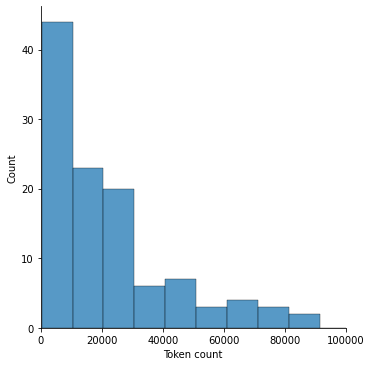

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(token_lens)
plt.xlim([0, 100000]);
plt.xlabel('Token count');

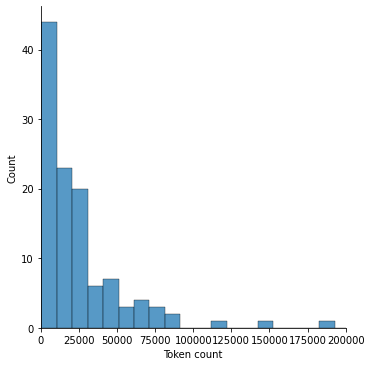

In [ ]:
sns.displot(token_lens)
plt.xlim([0, 200000]);
plt.xlabel('Token count');

Therefore, we should keep the max_len to 200,000

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-05

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            #truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

Train_data

In [ ]:
train_size = 0.8
train_dataset=train_data.sample(frac=train_size,random_state=200)
validation_dataset=train_data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(train_data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(validation_dataset, tokenizer, MAX_LEN)

FULL Dataset: (116, 2)
TRAIN Dataset: (93, 2)
VALIDATION Dataset: (23, 2)


In [ ]:
#training_set.targets=training_set.targets.to_numpy()
#training_set.Text=training_set.Text.to_numpy()

In [ ]:
lx=train_dataset.labels[1]
len(lx)

121

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [ ]:
len(validation_loader)

6

# **Build the** **Model** 

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 121)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Fine Tune

In [ ]:
Loss_history=[]
TrainAcc_history=[]
ValLoss_history=[]
ValAcc_history=[]
Micro_history=[]
Macro_history=[]


In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        preds = (outputs.detach().numpy() > 0.5).astype(int)
        #print(targets.flatten())
        #print(outputs)
        #print(preds.flatten)
        accuracy = metrics.accuracy_score(targets.flatten(), preds.flatten())
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        TrainAcc_history.append(accuracy)
        Loss_history.append(loss.item())
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()},  Train_accuracy:  {accuracy}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
          for _, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            val_targets = data['targets'].to(device, dtype = torch.float)
            one = torch.ones_like(val_targets)
            val_targets=torch.where(val_targets > 1, one, val_targets)
            val_outputs = model(ids, mask, token_type_ids)
            val_preds = (np.array(val_outputs) >= 0.5).astype(int)
            val_loss = loss_fn(val_outputs, val_targets)
            #targets=np.array(targets)
            #print(val_outputs)
            #print(len(val_outputs))
            #print(val_targets.flatten())
            #one = torch.ones_like(val_targets)
            #torch.where(val_targets > 1, one, val_targets)
            #print(val_targets.flatten())
            #print(len(val_targets.flatten()))
            #print(val_preds.flatten())
            #print(len(val_preds.flatten()))
            #preds = np.argmax(outputs, axis=1)
            val_accuracy = metrics.accuracy_score(val_targets.flatten(), val_preds.flatten())
            f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
            f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
            ValLoss_history.append(val_loss)
            ValAcc_history.append(val_accuracy)
            Micro_history.append(f1_score_micro)
            Macro_history.append(f1_score_macro)
            if _%5000==0:
              print(f'Epoch: {epoch}，  Validation Loss = {val_loss}，Accuracy Score = {accuracy}，F1 Score (Micro) = {f1_score_micro}，F1 Score (Macro) = {f1_score_macro}')
              
            

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  0.6450701355934143,  Train_accuracy:  0.71900826446281


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 0，  Validation Loss = 0.6461824178695679，Accuracy Score = 0.71900826446281，F1 Score (Micro) = 0.04477611940298507，F1 Score (Macro) = 0.007083825265643447
Epoch: 0，  Validation Loss = 0.6340379118919373，Accuracy Score = 0.7004132231404959，F1 Score (Micro) = 0.05084745762711864，F1 Score (Macro) = 0.009641873278236913
Epoch: 0，  Validation Loss = 0.6322630643844604，Accuracy Score = 0.8037190082644629，F1 Score (Micro) = 0.06504065040650407，F1 Score (Macro) = 0.012593467138921684
Epoch: 0，  Validation Loss = 0.6212121844291687，Accuracy Score = 0.762396694214876，F1 Score (Micro) = 0.045454545454545456，F1 Score (Macro) = 0.005509641873278236
Epoch: 0，  Validation Loss = 0.6046615839004517，Accuracy Score = 0.8388429752066116，F1 Score (Micro) = 0.037037037037037035，F1 Score (Macro) = 0.0033057851239669425
Epoch: 0，  Validation Loss = 0.6109080910682678，Accuracy Score = 0.8367768595041323，F1 Score (Micro) = 0.07692307692307693，F1 Score (Macro) = 0.007083825265643447
Epoch: 0，  Validation 

In [ ]:
pd.DataFrame(Loss_history).to_csv("Loss_history.csv",sep=',')
pd.DataFrame(TrainAcc_history).to_csv("TrainAcc_history.csv",sep=',')
pd.DataFrame(ValLoss_history).to_csv("ValLoss_history.csv",sep=',')
pd.DataFrame(ValAcc_history).to_csv("ValAcc_history.csv",sep=',')
pd.DataFrame(Micro_history).to_csv("Micro_history.csv",sep=',')
pd.DataFrame(Macro_history).to_csv("Macro_history.csv",sep=',')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
len(Loss_history)
#len(ValLoss_history)

1240

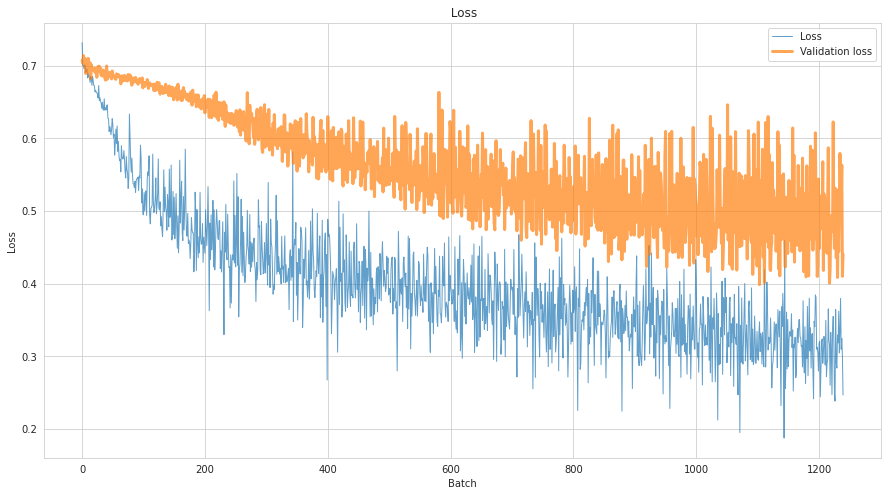

In [ ]:
plt.figure(figsize=(15,8))
plt.title(" Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(Loss_history,linewidth = 1,alpha = 0.7)
plt.plot(ValLoss_history[0:1240],linewidth = 3,alpha = 0.7)
plt.legend(labels=['Loss','Validation loss'])
plt.show()

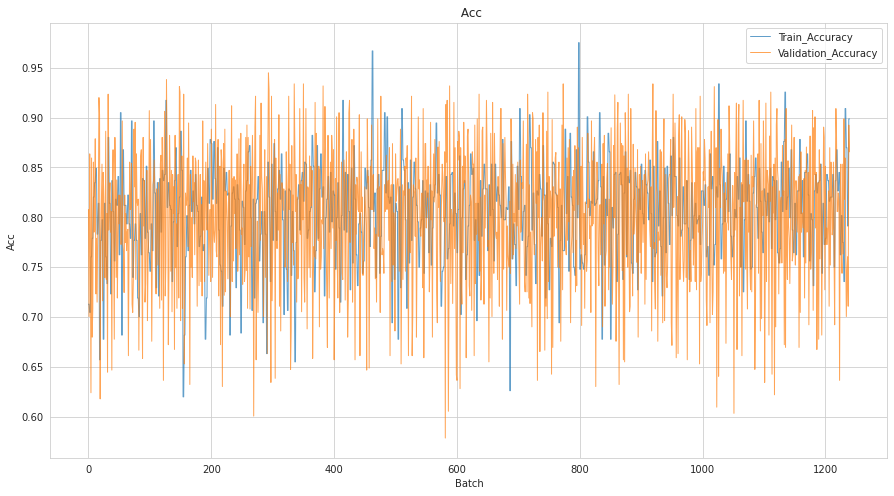

In [ ]:
plt.figure(figsize=(15,8))
plt.title(" Acc")
plt.xlabel("Batch")
plt.ylabel("Acc")
plt.plot(TrainAcc_history[0:1240],linewidth = 1,alpha = 0.7)
plt.plot(ValAcc_history[0:1240],linewidth = 1,alpha = 0.7)
plt.legend(labels=['Train_Accuracy','Validation_Accuracy'])
plt.show()

In [ ]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            one = torch.ones_like(targets)
            targets=torch.where(targets > 1, one, targets)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(1):
    val_outputs_1, val_targets_1 = validation(epoch)
    val_preds_1 = (np.array(val_outputs_1) >= 0.5).astype(int)
    val_targets_1=np.array(val_targets_1)
    print(val_preds_1)
    print(val_targets_1)
    #val_preds_1 = np.argmax(val_preds_1, axis=1)
    accuracy_1 = metrics.accuracy_score(val_targets_1.flatten(), val_preds_1.flatten())
    f1_score_micro_1 = metrics.f1_score(val_targets_1, val_preds_1, average='micro')
    f1_score_macro_1 = metrics.f1_score(val_targets_1, val_preds_1, average='macro')
    print(f"Accuracy Score = {accuracy_1}")
    print(f"F1 Score (Micro) = {f1_score_micro_1}")
    print(f"F1 Score (Macro) = {f1_score_macro_1}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 1. 0. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]]
Accuracy Score = 0.8056054617319439
F1 Score (Micro) = 0.241234221598878
F1 Score (Macro) = 0.0746241778701961


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
print(classification_report(val_targets_1, val_preds_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         0
          15       0.80      0.36      0.50        11
          16       1.00      0.17      0.29         6
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(val_targets_1.flatten(), val_preds_1.flatten()))

              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      2220
         1.0       0.57      0.15      0.24       563

    accuracy                           0.81      2783
   macro avg       0.70      0.56      0.56      2783
weighted avg       0.77      0.81      0.76      2783



## Second

In [16]:
train=pd.read_csv("Text_Attempt3.csv")
train['labels']=train[train.columns[13:134]].values.tolist()
new_train_data=train[['Text','labels']].copy()

In [11]:
#from sklearn.model_selection import StratifiedKFold

In [17]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
 text = BeautifulSoup(text, "lxml").text # HTML decoding
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
 text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
 text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
 return text

stemmer = SnowballStemmer("english")

def stemming(sentence):
  stemSentence = ""
  for word in sentence.split():
    stem = stemmer.stem(word)
    stemSentence += " "
    stemSentence += stem
    stemSentence += " "
    stemSentence = stemSentence.strip()
  return stemSentence

In [19]:
new_train_data['Text']=new_train_data['Text'].apply(clean_text)
new_train_data.Text[1]
new_train_data['Text']=new_train_data['Text'].apply(stemming)
new_train_data.Text[1]

'futur work autom employ productivityjanuari 2017execut summarysinc found 1990 mck insey global institut mgi sought develop deeper understand evolv global economi busi econom research arm mck insey compani mgi aim provid leader commerci public social sector fact insight base manag polici decis lauder institut univers pennsylvania rank mgi world numberon privatesector think tank 2015 global think tank index mgi research combin disciplin econom manag employ anali tical tool econom insight busi leader microtomacro methodolog examin microeconom industri trend better understand broad macroeconom forc af fect busi strategi public polici mgis indepth repor ts cover 20 countri 30 industri current research focus six theme product grow th natur resourc labor market evolut global financi market econom impact technolog innov urban recent repor ts assess econom benefit tackl gender inequ new era global competit chines innov digit global mgi led four mck insey compani senior par tner jacquesbughin j

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
sample_txt='futur work autom employ productivityjanuari 2017execut summarysinc found 1990 mck insey global institut mgi sought develop deeper understand evolv global economi busi econom research arm mck insey compani mgi aim provid leader commerci public social sector fact insight base manag polici decis lauder institut univers pennsylvania rank mgi world numberon privatesector think tank 2015 global think tank index mgi research combin disciplin econom manag employ anali tical tool econom insight busi leader microtomacro methodolog examin microeconom industri trend better understand broad macroeconom forc af fect busi strategi public polici mgis indepth repor ts cover 20 countri 30 industri current research focus six theme product grow th natur resourc labor market evolut global financi market econom impact technolog innov urban recent repor ts assess econom benefit tackl gender inequ new era global competit chines innov digit global mgi led four mck '

In [14]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: futur work autom employ productivityjanuari 2017execut summarysinc found 1990 mck insey global institut mgi sought develop deeper understand evolv global economi busi econom research arm mck insey compani mgi aim provid leader commerci public social sector fact insight base manag polici decis lauder institut univers pennsylvania rank mgi world numberon privatesector think tank 2015 global think tank index mgi research combin disciplin econom manag employ anali tical tool econom insight busi leader microtomacro methodolog examin microeconom industri trend better understand broad macroeconom forc af fect busi strategi public polici mgis indepth repor ts cover 20 countri 30 industri current research focus six theme product grow th natur resourc labor market evolut global financi market econom impact technolog innov urban recent repor ts assess econom benefit tackl gender inequ new era global competit chines innov digit global mgi led four mck 
   Tokens: ['fu', '##tur', 'work',

In [15]:
new_train_data

,Text,labels
0,technolog work v20the futur use beciti gps glo...,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ..."
1,futur work autom employ productivityjanuari 20...,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
2,african develop bankasian develop bankeuropean...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
3,world bank group flagship reportworld develop ...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,technolog futur work group twenti technolog fu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
...,...,...
111,rise justintim workforc ondemand work crowdwor...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
112,insight reportth global human capit report 201...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
113,organ ondemand represent voic collect bargain ...,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
114,insight reportth humancapit report2016term use...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            #truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [17]:
class NEWBERTClass(torch.nn.Module):
    def __init__(self):
        super(NEWBERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(768, 121)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

new_model = NEWBERTClass()
new_model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NEWBERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [29]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
#EPOCHS = 1
LEARNING_RATE = 1e-05

In [23]:
train_size = 0.8
new_train_dataset=new_train_data.sample(frac=train_size,random_state=200)
new_test_dataset=new_train_data.drop(new_train_dataset.index).reset_index(drop=True)
new_train_dataset = new_train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_train_data.shape))
print("TRAIN Dataset: {}".format(new_train_dataset.shape))
print("Test Dataset: {}".format(new_test_dataset.shape))

new_test_set = CustomDataset(new_test_dataset, tokenizer, MAX_LEN)
#new_training_set = CustomDataset(new_train_dataset, tokenizer, MAX_LEN)
#new_test_set = CustomDataset(new_test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (116, 2)
TRAIN Dataset: (93, 2)
Test Dataset: (23, 2)


In [24]:
new_Loss_history=[]
new_TrainAcc_history=[]
new_ValLoss_history=[]
new_ValAcc_history=[]
new_Micro_history=[]
new_Macro_history=[]

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
new_train_data['labels']

0      [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
1      [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
2      [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...
3      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
                             ...                        
111    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
112    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
113    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...
114    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
115    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: labels, Length: 116, dtype: object

In [22]:
new_train_dataset

,Text,labels
0,african develop bankasian develop bankeuropean...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
1,digit ai futur work imper europebrief noteprep...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ..."
2,execut summaryinclus futur work call actionima...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,xjuli 2016jaehe chang gari rynhart phu huynhbu...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,make roomreflect divers inclus futur workconte...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
88,cognit ai divers work aifutur tabl contentsmot...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
89,internationallabourorganizationsoci andsolidar...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
90,propos analysi group futur work lifelong learn...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
91,futur work wanta global dialogueforewordthi re...,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, ..."


In [23]:
i=92
df1=new_train_dataset.iloc[:i]
df2=new_train_dataset.iloc[i+1:]
frames=[df1,df2]
new_train_dataset_train=pd.concat(frames)
new_train_dataset_train

,Text,labels
0,african develop bankasian develop bankeuropean...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
1,digit ai futur work imper europebrief noteprep...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ..."
2,execut summaryinclus futur work call actionima...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,xjuli 2016jaehe chang gari rynhart phu huynhbu...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,make roomreflect divers inclus futur workconte...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
87,ioe briefunderstand futur workio briefundersta...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
88,cognit ai divers work aifutur tabl contentsmot...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
89,internationallabourorganizationsoci andsolidar...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
90,propos analysi group futur work lifelong learn...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [24]:
new_train_dataset_valid=new_train_dataset.iloc[1]
new_train_dataset_valid

Text      digit ai futur work imper europebrief noteprep...
labels    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...
Name: 1, dtype: object

In [25]:
i=0

## A Interrupted Attempt

In [ ]:
#skf = StratifiedKFold(n_splits=93, random_state=191)
for i in range(93):
  print("=" * 20)
  print(f"Fold {i + 1}")
  print("=" * 20)
  df1=new_train_dataset.iloc[:i]
  df2=new_train_dataset.iloc[i+1:]
  frames=[df1,df2]
  new_train_dataset_train=pd.concat(frames)
  new_train_dataset_valid=new_train_dataset.iloc[i]
  new_training_set = CustomDataset(new_train_dataset, tokenizer, MAX_LEN)
  new_validation_set = CustomDataset(new_train_dataset_valid, tokenizer, MAX_LEN)
  

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

  new_training_loader = DataLoader(new_training_set, **train_params)
  new_validation_loader = DataLoader(new_validation_set, **train_params)
  new_testing_loader = DataLoader(new_test_set, **test_params)
  
  def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
  optimizer = torch.optim.Adam(params =  new_model.parameters(), lr=LEARNING_RATE)
  new_model.train()
  for _,data in enumerate(new_training_loader, 0):

    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)
    one = torch.ones_like(targets)
    targets=torch.where(targets > 1, one, targets)
    outputs = new_model(ids, mask, token_type_ids)

    targets_list=targets.cpu().detach().numpy().tolist()
    outputs_list=torch.sigmoid(outputs).cpu().detach().numpy().tolist()
    preds_list = np.array(outputs_list) >= 0.5
    #print(targets_list)
    #print(outputs_list)
    #print(preds_list)
    accuracy = metrics.accuracy_score(targets_list, preds_list)
    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    new_TrainAcc_history.append(accuracy)
    new_Loss_history.append(loss.item())
    if _%5000==0:
        print( f'Loss:  {loss.item()},  Train_accuracy:  {accuracy}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    new_model.eval()
    with torch.no_grad():
      for _, data in enumerate(new_testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        val_targets = data['targets'].to(device, dtype = torch.float)
        one = torch.ones_like(val_targets)
        val_targets=torch.where(val_targets > 1, one, val_targets)
        val_outputs = new_model(ids, mask, token_type_ids)

        val_targets_list=val_targets.cpu().detach().numpy().tolist()   
        val_outputs_list=torch.sigmoid(val_outputs).cpu().detach().numpy().tolist()
        val_preds_list = np.array(val_outputs_list) >= 0.5
        val_loss = loss_fn(val_outputs, val_targets)
        #targets=np.array(targets)
        #print(val_outputs)
        #print(len(val_outputs))
        #print(val_targets.flatten())
        #one = torch.ones_like(val_targets)
        #torch.where(val_targets > 1, one, val_targets)
        #print(val_targets.flatten())
        #print(len(val_targets.flatten()))
        #print(val_preds.flatten())
        #print(len(val_preds.flatten()))
        #preds = np.argmax(outputs, axis=1)
        val_accuracy = metrics.accuracy_score(val_targets_list, val_preds_list)
        f1_score_micro = metrics.f1_score(val_targets_list, val_preds_list, average='micro')
        f1_score_macro = metrics.f1_score(val_targets_list, val_preds_list, average='macro')

        new_ValLoss_history.append(val_loss)
        new_ValAcc_history.append(val_accuracy)
        new_Micro_history.append(f1_score_micro)
        new_Macro_history.append(f1_score_macro)
        print(f'Validation Loss = {val_loss}，Accuracy Score = {accuracy}，F1 Score (Micro) = {f1_score_micro}，F1 Score (Macro) = {f1_score_macro}')
          
  i+=1
          

Fold 1


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Loss:  0.6690680384635925,  Train_accuracy:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


流式输出内容被截断，只能显示最后 5000 行内容。
Validation Loss = 0.3952806890010834，Accuracy Score = 0.0，F1 Score (Micro) = 0.10526315789473684，F1 Score (Macro) = 0.008264462809917356
Validation Loss = 0.2733803987503052，Accuracy Score = 0.0，F1 Score (Micro) = 0.25，F1 Score (Macro) = 0.01652892561983471
Validation Loss = 0.26722848415374756，Accuracy Score = 0.0，F1 Score (Micro) = 0.28571428571428575，F1 Score (Macro) = 0.01652892561983471
Validation Loss = 0.2697252631187439，Accuracy Score = 0.0，F1 Score (Micro) = 0.125，F1 Score (Macro) = 0.008264462809917356
Validation Loss = 0.5627983808517456，Accuracy Score = 0.0，F1 Score (Micro) = 0.2857142857142857，F1 Score (Macro) = 0.04132231404958678
Validation Loss = 0.4664645493030548，Accuracy Score = 0.0，F1 Score (Micro) = 0.1875，F1 Score (Macro) = 0.024793388429752067
Validation Loss = 0.6362745761871338，Accuracy Score = 0.0，F1 Score (Micro) = 0.4333333333333333，F1 Score (Macro) = 0.10743801652892562
Validation Loss = 0.8168863654136658，Accuracy Score = 0.0，F1 

In [26]:
#skf = StratifiedKFold(n_splits=93, random_state=191)
for i in range(93):
  print("=" * 20)
  print(f"Fold {i + 1}")
  print("=" * 20)
  df1=new_train_dataset.iloc[:i]
  df2=new_train_dataset.iloc[i+1:]
  frames=[df1,df2]
  new_train_dataset_train=pd.concat(frames)
  new_train_dataset_valid=new_train_dataset.iloc[i]
  new_training_set = CustomDataset(new_train_dataset, tokenizer, MAX_LEN)
  new_validation_set = CustomDataset(new_train_dataset_valid, tokenizer, MAX_LEN)
  

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

  new_training_loader = DataLoader(new_training_set, **train_params)
  new_validation_loader = DataLoader(new_validation_set, **train_params)
  new_testing_loader = DataLoader(new_test_set, **test_params)
  
  def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
  optimizer = torch.optim.Adam(params =  new_model.parameters(), lr=LEARNING_RATE)
  new_model.train()
  for _,data in enumerate(new_training_loader, 0):

    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)
    one = torch.ones_like(targets)
    targets=torch.where(targets > 1, one, targets)
    outputs = new_model(ids, mask, token_type_ids)

    targets_list=targets.cpu().detach().numpy().tolist()
    outputs_list=torch.sigmoid(outputs).cpu().detach().numpy().tolist()
    preds_list = (np.array(outputs_list) >= 0.5).astype(int)
    #print(targets_list)
    #print(len(targets_list))
    #print(outputs_list)
    #print(len(outputs_list))
    #print(preds_list)
    #print(len(preds_list))
    accuracy = metrics.accuracy_score(np.array(targets_list).flatten(), np.array(preds_list).flatten())
    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    new_TrainAcc_history.append(accuracy)
    new_Loss_history.append(loss.item())
    if _%5000==0:
        print( f'Loss:  {loss.item()},  Train_accuracy:  {accuracy}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    new_model.eval()
    with torch.no_grad():
      for _, data in enumerate(new_testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        val_targets = data['targets'].to(device, dtype = torch.float)
        one = torch.ones_like(val_targets)
        val_targets=torch.where(val_targets > 1, one, val_targets)
        val_outputs = new_model(ids, mask, token_type_ids)

        val_targets_list=val_targets.cpu().detach().numpy().tolist()   
        val_outputs_list=torch.sigmoid(val_outputs).cpu().detach().numpy().tolist()
        val_preds_list = (np.array(val_outputs_list) >= 0.5).astype(int)
        val_loss = loss_fn(val_outputs, val_targets)
        #targets=np.array(targets)
        #print(val_outputs)
        #print(len(val_outputs))
        #print(val_targets.flatten())
        #one = torch.ones_like(val_targets)
        #torch.where(val_targets > 1, one, val_targets)
        #print(val_targets.flatten())
        #print(len(val_targets.flatten()))
        #print(val_preds.flatten())
        #print(len(val_preds.flatten()))
        #preds = np.argmax(outputs, axis=1)
        val_accuracy = metrics.accuracy_score(np.array(val_targets_list).flatten(), np.array(val_preds_list).flatten())
        f1_score_micro = metrics.f1_score(val_targets_list, val_preds_list, average='micro')
        f1_score_macro = metrics.f1_score(val_targets_list, val_preds_list, average='macro')

        new_ValLoss_history.append(val_loss)
        new_ValAcc_history.append(val_accuracy)
        new_Micro_history.append(f1_score_micro)
        new_Macro_history.append(f1_score_macro)
        print(f'Validation Loss = {val_loss}，Accuracy Score = {accuracy}，F1 Score (Micro) = {f1_score_micro}，F1 Score (Macro) = {f1_score_macro}')
          
  i+=1
     

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Fold 1


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Loss:  0.7015848159790039,  Train_accuracy:  0.5433884297520661


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


流式输出内容被截断，只能显示最后 5000 行内容。
Validation Loss = 0.35724496841430664，Accuracy Score = 0.8615702479338843，F1 Score (Micro) = 0.3023255813953489，F1 Score (Macro) = 0.035733963006690274
Validation Loss = 0.501902163028717，Accuracy Score = 0.8615702479338843，F1 Score (Micro) = 0.19117647058823528，F1 Score (Macro) = 0.03730814639905549
Validation Loss = 0.42321303486824036，Accuracy Score = 0.8615702479338843，F1 Score (Micro) = 0.22680412371134023，F1 Score (Macro) = 0.04840613931523022
Validation Loss = 0.5222452282905579，Accuracy Score = 0.8615702479338843，F1 Score (Micro) = 0.24844720496894407，F1 Score (Macro) = 0.06513183785911059
Validation Loss = 0.5452975630760193，Accuracy Score = 0.8615702479338843，F1 Score (Micro) = 0.1794871794871795，F1 Score (Macro) = 0.05777253049980322
Validation Loss = 0.4136289656162262，Accuracy Score = 0.8615702479338843，F1 Score (Micro) = 0.14705882352941177，F1 Score (Macro) = 0.019008264462809916
Validation Loss = 0.40076783299446106，Accuracy Score = 0.845041322

In [27]:
pd.DataFrame(new_Loss_history).to_csv("new_Loss_history.csv",sep=',')
pd.DataFrame(new_TrainAcc_history).to_csv("new_TrainAcc_history.csv",sep=',')
pd.DataFrame(new_ValLoss_history).to_csv("new_ValLoss_history.csv",sep=',')
pd.DataFrame(new_ValAcc_history).to_csv("new_ValAcc_history.csv",sep=',')
pd.DataFrame(new_Micro_history).to_csv("new_Micro_history.csv",sep=',')
pd.DataFrame(new_Macro_history).to_csv("new_Macro_history.csv",sep=',')

In [30]:
import matplotlib.pyplot as plt

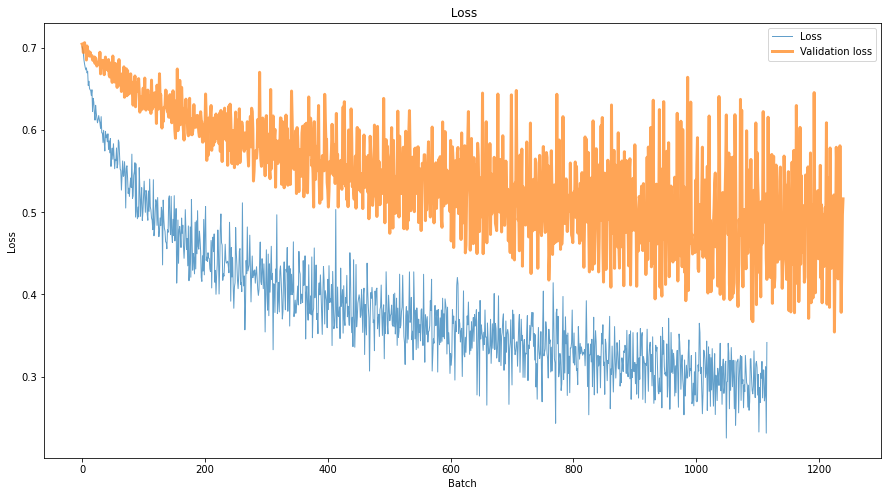

In [31]:
plt.figure(figsize=(15,8))
plt.title(" Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(new_Loss_history,linewidth = 1,alpha = 0.7)
plt.plot(new_ValLoss_history[0:1240],linewidth = 3,alpha = 0.7)
plt.legend(labels=['Loss','Validation loss'])
plt.show()

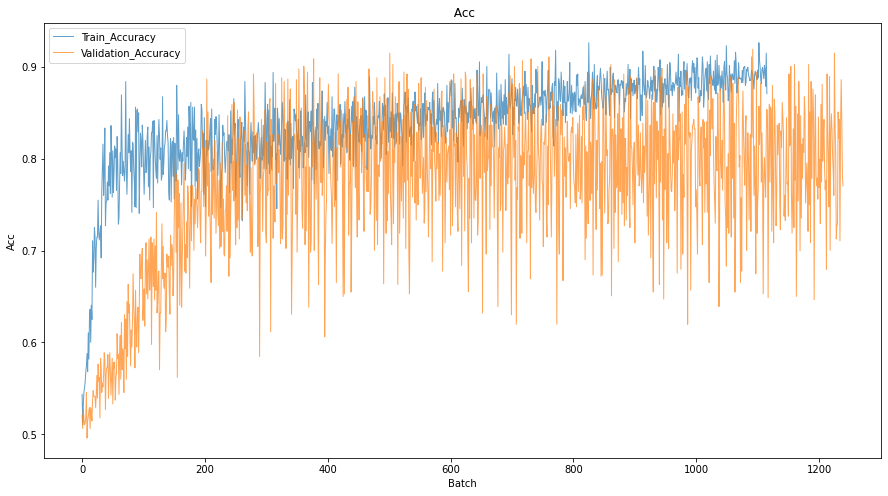

In [33]:
plt.figure(figsize=(15,8))
plt.title(" Acc")
plt.xlabel("Batch")
plt.ylabel("Acc")
plt.plot(new_TrainAcc_history[0:1240],linewidth = 1,alpha = 0.7)
plt.plot(new_ValAcc_history[0:1240],linewidth = 1,alpha = 0.7)
plt.legend(labels=['Train_Accuracy','Validation_Accuracy'])
plt.show()

In [35]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
print(classification_report(val_targets_list, val_preds_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       1.00      0.50      0.67         2
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
def validation(epoch):
    new_model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(new_testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            one = torch.ones_like(targets)
            targets=torch.where(targets > 1, one, targets)
            outputs = new_model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [43]:
for epoch in range(1):
    val_outputs_1, val_targets_1 = validation(epoch)
    val_preds_1 = (np.array(val_outputs_1) >= 0.5).astype(int)
    val_targets_1=np.array(val_targets_1)
    print(val_preds_1)
    print(val_targets_1)
    #val_preds_1 = np.argmax(val_preds_1, axis=1)
    accuracy_1 = metrics.accuracy_score(np.array(val_targets_1).flatten(), np.array(val_preds_1).flatten())
    f1_score_micro_1 = metrics.f1_score(val_targets_1, val_preds_1, average='micro')
    f1_score_macro_1 = metrics.f1_score(val_targets_1, val_preds_1, average='macro')
    print(f"Accuracy Score = {accuracy_1}")
    print(f"F1 Score (Micro) = {f1_score_micro_1}")
    print(f"F1 Score (Macro) = {f1_score_macro_1}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Accuracy Score = 0.8041681638519583
F1 Score (Micro) = 0.2684563758389262
F1 Score (Macro) = 0.08788696630669512


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [44]:
print(classification_report(val_targets_1, val_preds_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         0
          15       0.80      0.36      0.50        11
          16       0.67      0.33      0.44         6
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print(classification_report(val_targets_1.flatten(), val_preds_1.flatten()))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89      2220
         1.0       0.55      0.18      0.27       563

    accuracy                           0.80      2783
   macro avg       0.69      0.57      0.58      2783
weighted avg       0.77      0.80      0.76      2783



In [25]:
class NEWBERTClass(torch.nn.Module):
    def __init__(self):
        super(NEWBERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(768, 121)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

new_modellr = NEWBERTClass()
new_modellr.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NEWBERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [26]:
new_Loss_historylr=[]
new_TrainAcc_historylr=[]
new_ValLoss_historylr=[]
new_ValAcc_historylr=[]
new_Micro_historylr=[]
new_Macro_historylr=[]

In [27]:
import torch.nn as nn

In [30]:
for i in range(93):
  print("=" * 20)
  print(f"Fold {i + 1}")
  print("=" * 20)
  df1=new_train_dataset.iloc[:i]
  df2=new_train_dataset.iloc[i+1:]
  frames=[df1,df2]
  new_train_dataset_train=pd.concat(frames)
  new_train_dataset_valid=new_train_dataset.iloc[i]
  new_training_set = CustomDataset(new_train_dataset, tokenizer, MAX_LEN)
  new_validation_set = CustomDataset(new_train_dataset_valid, tokenizer, MAX_LEN)
  

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

  new_training_loader = DataLoader(new_training_set, **train_params)
  new_validation_loader = DataLoader(new_validation_set, **train_params)
  new_testing_loader = DataLoader(new_test_set, **test_params)
  
  def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
  optimizer = torch.optim.Adam(params =  new_modellr.parameters(), lr=LEARNING_RATE)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [20,50,90], gamma=0.5)
  new_modellr.train()
  for _,data in enumerate(new_training_loader, 0):

    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)
    one = torch.ones_like(targets)
    targets=torch.where(targets > 1, one, targets)
    outputs = new_modellr(ids, mask, token_type_ids)

    targets_list=targets.cpu().detach().numpy().tolist()
    outputs_list=torch.sigmoid(outputs).cpu().detach().numpy().tolist()
    preds_list = (np.array(outputs_list) >= 0.5).astype(int)
    #print(targets_list)
    #print(len(targets_list))
    #print(outputs_list)
    #print(len(outputs_list))
    #print(preds_list)
    #print(len(preds_list))
    accuracy = metrics.accuracy_score(np.array(targets_list).flatten(), np.array(preds_list).flatten())
    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    new_TrainAcc_historylr.append(accuracy)
    new_Loss_historylr.append(loss.item())
    if _%5000==0:
        print( f'Loss:  {loss.item()},  Train_accuracy:  {accuracy}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    new_modellr.eval()
    with torch.no_grad():
      for _, data in enumerate(new_testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        val_targets = data['targets'].to(device, dtype = torch.float)
        one = torch.ones_like(val_targets)
        val_targets=torch.where(val_targets > 1, one, val_targets)
        val_outputs = new_modellr(ids, mask, token_type_ids)

        val_targets_list=val_targets.cpu().detach().numpy().tolist()   
        val_outputs_list=torch.sigmoid(val_outputs).cpu().detach().numpy().tolist()
        val_preds_list = (np.array(val_outputs_list) >= 0.5).astype(int)
        val_loss = loss_fn(val_outputs, val_targets)
        #targets=np.array(targets)
        #print(val_outputs)
        #print(len(val_outputs))
        #print(val_targets.flatten())
        #one = torch.ones_like(val_targets)
        #torch.where(val_targets > 1, one, val_targets)
        #print(val_targets.flatten())
        #print(len(val_targets.flatten()))
        #print(val_preds.flatten())
        #print(len(val_preds.flatten()))
        #preds = np.argmax(outputs, axis=1)
        val_accuracy = metrics.accuracy_score(np.array(val_targets_list).flatten(), np.array(val_preds_list).flatten())
        f1_score_micro = metrics.f1_score(val_targets_list, val_preds_list, average='micro')
        f1_score_macro = metrics.f1_score(val_targets_list, val_preds_list, average='macro')

        new_ValLoss_historylr.append(val_loss)
        new_ValAcc_historylr.append(val_accuracy)
        new_Micro_historylr.append(f1_score_micro)
        new_Macro_historylr.append(f1_score_macro)
        print(f'Validation Loss = {val_loss}，Accuracy Score = {accuracy}，F1 Score (Micro) = {f1_score_micro}，F1 Score (Macro) = {f1_score_macro}')
          
  i+=1

Fold 1


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Loss:  0.6226629614830017,  Train_accuracy:  0.699896694214876


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Validation Loss = 0.6114456057548523，Accuracy Score = 0.699896694214876，F1 Score (Micro) = 0.21739130434782608，F1 Score (Macro) = 0.05767593288254445
Validation Loss = 0.6369147896766663，Accuracy Score = 0.699896694214876，F1 Score (Micro) = 0.33702882483370294，F1 Score (Macro) = 0.11769231686587059
Validation Loss = 0.6023411154747009，Accuracy Score = 0.699896694214876，F1 Score (Micro) = 0.27338129496402874，F1 Score (Macro) = 0.06937557392102846
Validation Loss = 0.6181463003158569，Accuracy Score = 0.7417355371900827，F1 Score (Micro) = 0.299492385786802，F1 Score (Macro) = 0.09041417719103668
Validation Loss = 0.6080395579338074，Accuracy Score = 0.7417355371900827，F1 Score (Micro) = 0.29916897506925205，F1 Score (Macro) = 0.09705083713348177
Validation Loss = 0.6194678544998169，Accuracy Score = 0.7417355371900827，F1 Score (Micro) = 0.22012578616352202，F1 Score (Macro) = 0.08100485373212644
Validation Loss = 0.6077537536621094，Accuracy Score = 0.7024793388429752，F1 Score (Micro) = 0.22905

KeyboardInterrupt: ignored

In [56]:
pd.DataFrame(new_Loss_historylr).to_csv("new_Loss_historylr.csv",sep=',')
pd.DataFrame(new_TrainAcc_historylr).to_csv("new_TrainAcc_historylr.csv",sep=',')
pd.DataFrame(new_ValLoss_historylr).to_csv("new_ValLoss_historylr.csv",sep=',')
pd.DataFrame(new_ValAcc_historylr).to_csv("new_ValAcc_historylr.csv",sep=',')
pd.DataFrame(new_Micro_historylr).to_csv("new_Micro_historylr.csv",sep=',')
pd.DataFrame(new_Macro_historylr).to_csv("new_Macro_historylr.csv",sep=',')

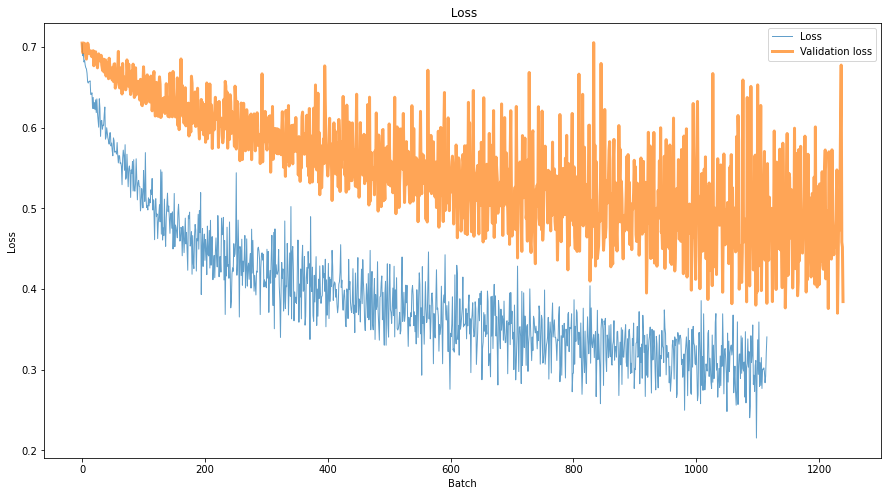

In [57]:
plt.figure(figsize=(15,8))
plt.title(" Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(new_Loss_historylr,linewidth = 1,alpha = 0.7)
plt.plot(new_ValLoss_historylr[0:1240],linewidth = 3,alpha = 0.7)
plt.legend(labels=['Loss','Validation loss'])
plt.show()

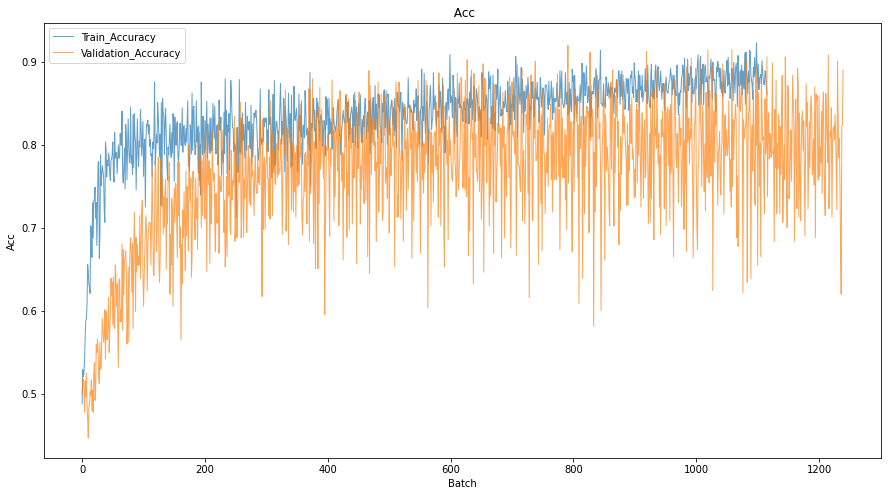

In [58]:
plt.figure(figsize=(15,8))
plt.title(" Acc")
plt.xlabel("Batch")
plt.ylabel("Acc")
plt.plot(new_TrainAcc_historylr[0:1240],linewidth = 1,alpha = 0.7)
plt.plot(new_ValAcc_historylr[0:1240],linewidth = 1,alpha = 0.7)
plt.legend(labels=['Train_Accuracy','Validation_Accuracy'])
plt.show()

In [ ]:
def validation(epoch):
    new_modellr.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(new_testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            one = torch.ones_like(targets)
            targets=torch.where(targets > 1, one, targets)
            outputs = new_modellr(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(1):
    val_outputs_lr, val_targets_lr = validation(epoch)
    val_preds_lr = (np.array(val_outputs_lr) >= 0.5).astype(int)
    val_targets_lr=np.array(val_targets_lr)
    print(val_preds_lr)
    print(val_targets_lr)
    #val_preds_lr = np.argmax(val_preds_lr, axis=1)
    accuracy_lr = metrics.accuracy_score(np.array(val_targets_lr).flatten(), np.array(val_preds_lr).flatten())
    f1_score_micro_lr = metrics.f1_score(val_targets_lr, val_preds_lr, average='micro')
    f1_score_macro_lr = metrics.f1_score(val_targets_lr, val_preds_lr, average='macro')
    print(f"Accuracy Score = {accuracy_lr}")
    print(f"F1 Score (Micro) = {f1_score_micro_lr}")
    print(f"F1 Score (Macro) = {f1_score_macro_lr}")

In [7]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
print(classification_report(val_targets_lr, val_preds_lr))

In [62]:
print(classification_report(val_targets_lr.flatten(), val_preds_lr.flatten()))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89      2220
         1.0       0.55      0.18      0.27       563

    accuracy                           0.80      2783
   macro avg       0.69      0.57      0.58      2783
weighted avg       0.77      0.80      0.76      2783

